In [1]:
from EffectiveXGBoost import *
from sklearn import tree
import matplotlib.pyplot as plt
import seaborn.objects as so

In [2]:
path_url = 'https://github.com/mattharrison/datasets/raw/master/data/kaggle-survey-2018.zip'
file_name = 'kaggle-survey-2018.zip'
dataset = 'multipleChoiceResponses.csv'

survey_df = extract_dataset(path_url, file_name, dataset)
final_df = prep_data(survey_df)
final_df.head()

G:\My Drive\SisengAI\AlgorithmicTrading\code_rebuilding\MattHarrison\EffectiveXGBoost\EffectiveXGBoost.py:56: DtypeWarning: Columns (0,2,8,10,21,23,24,25,26,27,28,44,56,64,83,85,87,107,109,123,125,150,157,172,174,194,210,218,219,223,246,249,262,264,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,304,306,325,326,329,341,368,371,384,385,389,390,391,393,394) have mixed types. Specify dtype option on import or set low_memory=False.
  all_df = pd.read_csv(z.open(dataset))


,Q1,Q3,age,education,major,years_exp,compensation,python,r,sql
1,Female,United States of America,45,20.0,other,NaN,0,0,0,0
2,Male,Indonesia,30,16.0,eng,5.0,10000,0,0,1
3,Female,United States of America,30,18.0,cs,0.0,0,0,1,0
4,Male,United States of America,35,18.0,other,NaN,0,1,1,1
5,Male,India,22,18.0,stat,0.0,0,0,0,1


In [3]:
pline = pipeline.Pipeline(
    [('tweak', PrepDataTransformer()),
    ('cat', encoding.OneHotEncoder(top_categories=5, drop_last=True,
    variables=['Q1', 'Q3', 'major'])),
    ('num_impute', imputation.MeanMedianImputer(imputation_method='median',
                variables=['education', 'years_exp']))]
    )

X, y = prepX_y(survey_df, 'Q6')

sur_X_train, sur_X_test, sur_y_train, sur_y_test = (model_selection
                                    .train_test_split(X, y, 
                                                      test_size=.3, 
                                                      random_state=42, 
                                                      stratify=y)
                                                        )

X_train = pline.fit_transform(sur_X_train, sur_y_train)
X_test = pline.transform(sur_X_test)
X_train.sample(7)

,age,education,years_exp,compensation,python,r,sql,Q1_Male,Q1_Female,Q1_Prefer not to say,Q1_Prefer to self-describe,Q3_United States of America,Q3_India,Q3_China,major_cs,major_other,major_eng,major_stat
8692,22,18.0,1.0,0,1,1,1,1,0,0,0,0,1,0,0,0,1,0
15767,22,18.0,2.0,0,1,0,1,1,0,0,0,1,0,0,1,0,0,0
13369,25,18.0,3.0,150000,1,0,1,0,1,0,0,1,0,0,0,0,1,0
9114,30,16.0,10.0,10000,1,1,1,1,0,0,0,0,1,0,0,0,1,0
267,22,16.0,1.0,0,1,0,1,1,0,0,0,0,1,0,1,0,0,0
10714,22,18.0,3.0,0,1,0,1,0,1,0,0,1,0,0,1,0,0,0
20886,30,18.0,10.0,20000,0,0,0,1,0,0,0,0,1,0,0,0,1,0


## 5.1 Scikit-learn stump on real data
We will create the stump and visualize it. We will use our pipeline to prepare the training
data. Remember that the pipeline uses _pandas_ code to clean up the raw data, then we use
categorical encoding on the non-numeric columns, and finally, we fill in the missing values
for education level and experience.

We will feed the raw data, `sur_X_train`, into the `.fit_transform` method of the pipeline and
get out the cleaned-up training data, `X_train`. Then we will create a stump and train it with the
`.fit` method:

In [4]:
stump_dt = tree.DecisionTreeClassifier(max_depth=1)
X_train = pline.fit_transform(sur_X_train)
stump_dt.fit(X_train, sur_y_train)

DecisionTreeClassifier(max_depth=1)

[Text(0.5, 0.75, 'r <= 0.5\ngini = 0.496\nsamples = 2110\nvalue = [1153, 957]\nclass = Data Scientist'),
 Text(0.25, 0.25, 'gini = 0.493\nsamples = 1484\nvalue = [653, 831]\nclass = Software Engineer'),
 Text(0.75, 0.25, 'gini = 0.322\nsamples = 626\nvalue = [500, 126]\nclass = Data Scientist')]

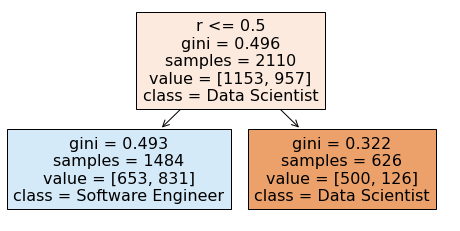

In [5]:
fig, ax = plt.subplots(figsize=(8, 4))
features = list(c for c in X_train.columns)
tree.plot_tree(stump_dt, feature_names=features,
               filled=True, 
               class_names=stump_dt.classes_,
               ax=ax)

We can evaluate the accuracy of our model with the .score method. We call this method on
the holdout set, `X_test`.

In [6]:
X_test = pline.transform(sur_X_test)
stump_dt.score(X_test, sur_y_test)

0.6243093922651933

This model classified $62\%$ of the occupations correctly by just looking at a single
column, the `R` column.

We can create a baseline model
using the `DummyClassifier`. This classifier just predicts the most common label, in our case
`'Data Scientist'`. This provides a baseline score that our
model should be able to beat. If we can’t beat that model, we shouldn’t be using machine
learning.

In [7]:
from sklearn import dummy
dummy_model = dummy.DummyClassifier()
dummy_model.fit(X_train, sur_y_train)
dummy_model.score(X_test, sur_y_test)

0.5458563535911602

The baseline performance is $54\%$ accuracy (which is the percent of values that are
`'Data Scientist'`). Our stump accuracy is better than the baseline, which doesn't necessarily qualify a model as _"good"_; but it does indicate that the model is potentially
useful.

## 5.2 Decision Stump with XGBoost
XGBoost uses  _boosting_ and _gradient descent_ instead of the Gini calculation to decide how to make calculations. To improve models, _boosting_ uses a model and combines it with other models. The subsequent models are trained from the error of the previous model with
the goal to reduce that error.  This process of
minimizing the error is specified into an objective function such that the _gradient descent_
algorithm can be applied.

We will now create a stump with XGBoost by setting the parameter `n_estimators` to $1$ and see if it
performs similarly to the scikit-learn stump. However unlike scikit-learn, XGBoost
does not work with string labels but integer values. When we run it we get the following error:

```python
ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1], got ['Data Scientist' 'Software Engineer']
```

we will use the `LabelEncoder` class from scikit-learn
to convert the labels to numbers. The `label_encoder` stores attributes that are useful when
preparing data for future predictions.

In [8]:
sur_y_test.iloc[:5]

7894     Software Engineer
10541       Data Scientist
21353       Data Scientist
13879    Software Engineer
21971    Software Engineer
Name: Q6, dtype: object

In [9]:
import xgboost as xgb
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
y_train = label_encoder.fit_transform(sur_y_train)
y_test = label_encoder.transform(sur_y_test)
y_test[:5]

array([1, 0, 0, 1, 1])

The `label_encoder` returns $1s$ and $0s$. Running the `.classes_` will show us what we have encoded. The index of these values is the
number that the encoder uses.

In [10]:
label_encoder.classes_

array(['Data Scientist', 'Software Engineer'], dtype=object)

Because 'Data Scientist' is in index 0 in `.classes_`, it is the $0$ value in the training labels.
The $1$ represents 'Software Engineer'. This is also called the positive label.

The `label_encoder` has an `.inverse_transform` method that reverses the transformation we have seen.

```python
label_encoder.inverse_transform([0, 1])
```

Let us continue with our model building.

In [11]:
sur_stump = xgb.XGBClassifier(n_estimators=1, max_depth=1)
sur_stump.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=1, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=1, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [12]:
sur_stump.score(X_test, y_test)

0.6243093922651933

The XGBoost stump performs similarly to the scikit-learn decision tree.

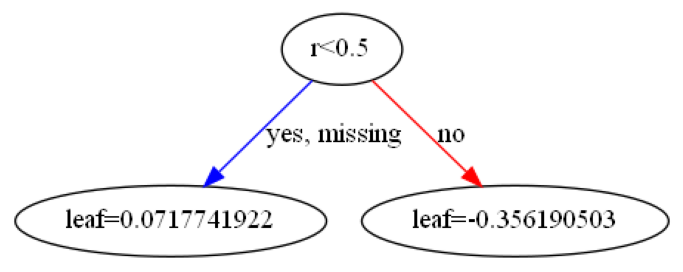

In [13]:
fig, ax = plt.subplots(figsize=(12, 12))
_=xgb.plot_tree(sur_stump, num_trees=0, ax=ax)

## 5.3 Values in the XGBoost Tree

The numbers in the leaves of the export are called _logits_ by Statisticians and they represent the probabilities or  the logarithm of the odds of the positive value.

When we calculate the inverse logit scores with the values from the nodes in the tree,
we get the probability of the prediction.  If a survey respondent does not use the `R` language,
the leaf value is $.0717741922$. The inverse logit of that is $.518$, or $51.8\%$. Because this value is
greater than $.5$, we assume the positive label or class of _"Software Engineer"_.

Let’s see what probability comes out when we pass in $.0717741922$ for the left node and $-0.356190503$ for the right node:

In [15]:
inv_logit(.0717741922)

0.5179358489487103

In [17]:
inv_logit(-0.356190503)

0.41188204953156665

From the above results, the inverse logit for the left node is $51.8\%$, while that of the right node is $41.1\%$. Because the number for the right node is below $.5$, we
do not classify it as the second option but rather choose "_Data Scientist"_.

If a user uses $R$, they have a higher likelihood of being a _"Data Scientist"_ $(1-.41 or
59\%)$, than a _"Software Engineer"_ who doesn’t use $R$ $(.518 or 52\%)$. In other words, using
$R$ pushes one more toward _data science_ than not using $R$ pushes one toward _software
engineering_.

Let us now plot the _inverse logit_ function below.

Text(-3, 0.4, 'Predict Negative')

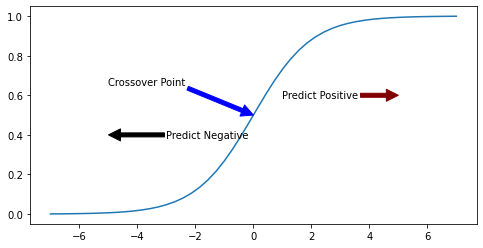

In [25]:
fig, ax = plt.subplots(figsize=(8, 4))
vals = np.linspace(-7, 7)
ax.plot(vals, inv_logit(vals))
ax.annotate('Crossover Point', (0,.5), (-5,.65), arrowprops={'color':'blue'})
ax.annotate('Predict Positive', (5,.6), (1,.6), va='center', arrowprops={'color':'maroon'})
ax.annotate('Predict Negative', (-5,.4), (-3,.4), va='center', arrowprops={'color':'k'})

When the $x$ values are above $0$, the $y$ value will be $> .5$ (Software
Engineer). When they are below $0$, the values will be $< .5$ (Data Scientist).


1. `fig, ax = plt.subplots(figsize=(8, 4))`: This line creates a new figure and a single subplot with a size of 8 inches by 4 inches. The figure and axes objects are assigned to the variables `fig` and `ax`, respectively.

2. `vals = np.linspace(-7, 7)`: This line creates an array of evenly spaced values between -7 and 7 using the `linspace` function from the `numpy` library. The resulting array is assigned to the variable `vals`.

3. `ax.plot(vals, inv_logit(vals))`: This line plots the values in the `vals` array on the x-axis and the result of calling the `inv_logit` function with `vals` as an argument on the y-axis. The plot is added to the axes object `ax`.

4. `ax.annotate('Crossover Point', (0,.5), (-5,.8), arrowprops={'color':'blue'})`: This line adds an annotation to the plot at the point `(0, .5)` with the text `'Crossover point'`. An arrow is drawn from the text to the point `(-5, .8)` with a blue color.

5. `ax.annotate('Predict Positive', (5,.6), (1,.6), va='center', arrowprops={'color':'maroon'})`: This line adds another annotation to the plot at the point `(5, .6)` with the text `'Predict Positive'`. An arrow is drawn from the text to the point `(1, .6)` with a maroon color. The text is vertically centered.

6. `ax.annotate('Predict Negative', (-5,.4), (-3,.4), va='center', arrowprops={'color':'k'})`: This line adds a third annotation to the plot at the point `(-5, .4)` with the text `'Predict Negative'`. An arrow is drawn from the text to the point `(-3, .4)` with a black color. The text is also vertically centered.


In [ ]:
import graphviz

filename='img/stump_xg_kag.dot'
# Read the .dot file
with open(filename, 'r') as f:
    dot_graph = f.read()

# Create a graph from the .dot data
graph = graphviz.Source(dot_graph)

# Render the graph
graph.view()